In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# DoubleConv Class to perform two layer Convolution
class DoubleConv(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,3,padding=1), 
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_ch,out_ch,3,padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True)
            )
    def forward(self,x):
        return self.conv(x)
# Unter Class with shown architecture
class UNet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(UNet,self).__init__()
        self.conv1 = DoubleConv(in_ch,64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512,1024)
        self.up6 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv6 = DoubleConv(1024,512)
        self.up7 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.conv7 = DoubleConv(512,256)
        self.up8 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv8 = DoubleConv(256,128)
        self.up9 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv9 = DoubleConv(128,128)
        self.conv9 = DoubleConv(128,64)
        self.conv10 = nn.Conv2d(64,out_ch,1)

    def forward(self,x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6,c4],dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7,c3],dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8,c2],dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9,c1],dim=1)
        c9 = self.conv9(merge9)
        out = c9
        c10 = self.conv10(c9)
        out = c10        
        out = nn.Softmax()(c10) 
        return out

### We used **U-Net** model whose architecture is shown Below

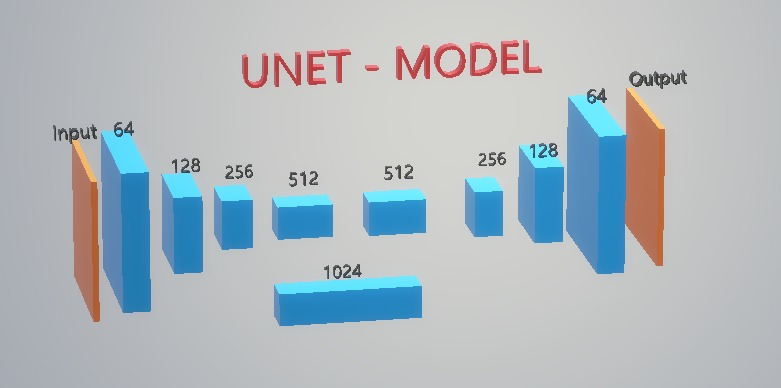

In [ ]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
  def __init__(self):
    super(DiceLoss, self).__init__()
  def	forward(self, inputs, target):
    N = target.size(0)
    smooth = 1
    input_flat = inputs.view(N, -1)
    target_flat = target.view(N, -1)
 
    intersection = input_flat * target_flat
 
    loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
    loss = 1 - loss.sum() / N
 
    return loss
 
class MulticlassDiceLoss(nn.Module):
	"""
	requires one hot encoded target. Applies DiceLoss on each class iteratively.
	requires input.shape[0:1] and target.shape[0:1] to be (N, C) where N is
	  batch size and C is number of classes
	"""
	def __init__(self):
		super(MulticlassDiceLoss, self).__init__()
 
	def forward(self, inputs, target, weights=None):
        
		target = torch.nn.functional.one_hot(target.long()).permute(0,3,1,2)
		inputs = torch.nn.functional.softmax(inputs,dim=1)

		C = target.shape[1] 
		# if weights is None:
		# 	weights = torch.ones(C) #uniform weights for all classes
 
		dice = DiceLoss()
		totalLoss = 0
 
		for i in range(C):
			diceLoss = dice(inputs[:,i], target[:,i])
			if weights is not None:
				diceLoss *= weights[i]
			totalLoss += diceLoss
 
		return totalLoss

In [ ]:
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/seamai-facies-challenge/v0.1/public/data_train.npz
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/seamai-facies-challenge/v0.1/public/data_test_1.npz
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/seamai-facies-challenge/v0.1/public/labels_train.npz

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset#
from torch import optim

import numpy as np
sei_patch = np.load('/content/data_train.npz')['data']
lab_patch = np.load('/content/labels_train.npz')['labels']

import cv2
from tqdm.notebook import tqdm
import datetime 
from IPython.display import HTML
import cv2

In [ ]:
sei_patch.shape , lab_patch.shape

((1006, 782, 590), (1006, 782, 590))

In [ ]:
lab_patch[lab_patch==6] = 0

In [ ]:
#np.unique(lab_patch)

In [ ]:
training_img_data = []
training_label_data = []

#MAX_AMP = np.amax(sei_patch)*1.05 # I normalize over the max amp cos I wanna

# Define the X lines slices for training
for i in tqdm(range(0, sei_patch.shape[1])):
  img = sei_patch[:, i, :]
  label = lab_patch[:, i, :]

  #img = img/MAX_AMP
  #img = fast_glcm_entropy(img)
  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (256, 512), interpolation=cv2.INTER_AREA)
  label = cv2.resize(label, (256, 512), interpolation = cv2.INTER_NEAREST)
  label = label.astype(int)
  #img = np.clip(img, 0, 255)
  #img = (img*255).astype(int)

  #img = cv2.merge([img,img,img]) #we need 3 channels baby

  #cv2.imwrite('/content/training_imgs/image_x_%03d.png' % i, img)
  #cv2.imwrite('/content/training_labels/image_x_%03d.png' % i, label)

  training_img_data.append(img) 
  training_label_data.append(label)

# Define the Y lines slices for training
for i in tqdm(range(0, sei_patch.shape[2])):
  img = sei_patch[:, :, i]
  label = lab_patch[:, :, i]

  #img = img/MAX_AMP
  #img = fast_glcm_entropy(img)
  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (256, 512), interpolation=cv2.INTER_AREA)
  label = cv2.resize(label, (256, 512), interpolation = cv2.INTER_NEAREST)
  label = label.astype(int)

  #img = np.clip(img, 0, 255)
  #img = (img*255).astype(int)
  
  #img = cv2.merge([img,img,img]) #we need 3 channels baby

  #cv2.imwrite('/content/training_imgs/image_y_%03d.png' % i, img)
  #cv2.imwrite('/content/training_labels/image_y_%03d.png' % i, label)
  training_img_data.append(img) 
  training_label_data.append(label)


In [ ]:
training_img_data = np.asarray(training_img_data)
training_label_data = np.asarray(training_label_data)
training_label_data = np.array(training_label_data,dtype=int)
training_img_data.shape, training_label_data.shape

((1372, 512, 256), (1372, 512, 256))

In [ ]:
#np.unique(training_label_data)

In [ ]:
class DataGenerator(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set

    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        batch_x = self.x[index]
        batch_y = self.y[index]
        return np.expand_dims(batch_x,axis=0), batch_y

e=1e-2

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


def train(model,optimizer,dataload,num_epochs,device):
    acc_history  = []
    loss_history = []
    miou_history = []
    for epoch in range(num_epochs):
        print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        since = time.time()
        dataset_size = len(dataload.dataset)
        epoch_loss = 0
        epoch_acc  = 0

        for idx,(x, y) in enumerate(dataload):                 
            optimizer.zero_grad()             
            inputs = x.to(device)
            labels = y.to(device)
            outputs = model(inputs)           
            criterion1 = MulticlassDiceLoss() 
            loss1 = criterion1(outputs,labels.long())
            criterion2 = torch.nn.CrossEntropyLoss()
            loss2 = criterion2(torch.log(outputs),labels.long())
            loss = e*loss1+loss2
            acc  = accuracy(outputs,labels)
            loss.backward()                  
            optimizer.step()                  
            
            epoch_loss += loss.item()
            epoch_acc+= acc
            loss_history.append(loss.item())
            acc_history.append(acc)
            if (idx+1)%10==0:
              print("%d/%d,train_loss:%0.3f,accuracy:%0.3f" % (idx+1, dataset_size // dataload.batch_size, loss.item(),acc))

        time_elapsed = time.time() - since     
        all_epoch_loss=epoch_loss/len(dataload)
        all_epoch_acc=epoch_acc/len(dataload)
        print("epoch %d loss:%0.3f accuracy:%0.3f " % (epoch, all_epoch_loss,all_epoch_acc))
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model,"/content/model_0.pth")      
    return model,loss_history,acc_history

In [ ]:
# from dice_loss import *
!CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1,6).to(device)
train_dataset = DataGenerator(x_set=training_img_data,y_set=training_label_data) 
dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
optimizer = optim.Adam(model.parameters(),lr=1e-2)
num_epochs=14
model_0,loss,acc=train(model,optimizer,dataloader,num_epochs,device)

Starting epoch 1/14
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10/137,train_loss:1.159,accuracy:0.560
20/137,train_loss:0.906,accuracy:0.704
30/137,train_loss:0.714,accuracy:0.762
40/137,train_loss:0.624,accuracy:0.796
50/137,train_loss:0.544,accuracy:0.814
60/137,train_loss:0.471,accuracy:0.839
70/137,train_loss:0.394,accuracy:0.854
80/137,train_loss:0.392,accuracy:0.863
90/137,train_loss:0.354,accuracy:0.877
100/137,train_loss:0.314,accuracy:0.894
110/137,train_loss:0.282,accuracy:0.907
120/137,train_loss:0.261,accuracy:0.917
130/137,train_loss:0.318,accuracy:0.903
epoch 0 loss:0.552 accuracy:0.804 
Training complete in 6m 13s
Starting epoch 2/14
----------
10/137,train_loss:0.285,accuracy:0.910
20/137,train_loss:0.252,accuracy:0.923
30/137,train_loss:0.222,accuracy:0.928
40/137,train_loss:0.210,accuracy:0.935
50/137,train_loss:0.211,accuracy:0.934
60/137,train_loss:0.177,accuracy:0.945
70/137,train_loss:0.186,accuracy:0.943
80/137,train_loss:0.180,accuracy:0.944
90/137,train_loss:0.163,accuracy:0.952
100/137,train_loss:0.173,accuracy:0.947
110/

In [ ]:
def seisfacies_predict(section,patch_size=256,overlap=0,onehot=0): 
    m1,m2 = section.shape
    os    = overlap                                 
    n1,n2 = 512,patch_size           
    c1 = int(np.round((m1+os)/(n1-os)+0.5))
    c2 = int(np.round((m2+os)/(n2-os)+0.5))
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os

    gp = np.zeros((p1,p2),dtype=np.single)     
    gy = np.zeros((6,p1,p2),dtype=np.single)    
    gs = np.zeros((n1,n2),dtype=np.single) 
    
    gp[0:m1,0:m2]=section     

    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2                
            #predict
            gs[:,:]=gp[b1:e1,b2:e2]
            x=gs.reshape(1,1,512,256)
            Y_patch= model(torch.from_numpy(x)).squeeze()
            p=F.softmax(Y_patch, dim=0).detach().numpy()
            gy[:,b1:e1,b2:e2]= gy[:,b1:e1,b2:e2]+p
    
    gy_onehot = gy[:,0:m1,0:m2]            
    #onehot2label
    gy_label =np.argmax(gy_onehot,axis=0)

    if onehot==0:
        return gy_label
    if onehot==1:
        return gy_label,gy_onehot

In [ ]:
#plt.imshow(training_label_data[180])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


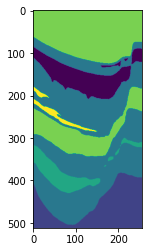

In [ ]:
model = torch.load("model_0.pth",map_location='cpu')
gy_label,gy_onehot=seisfacies_predict(training_img_data[420],onehot=1)
plt.imshow(gy_label)

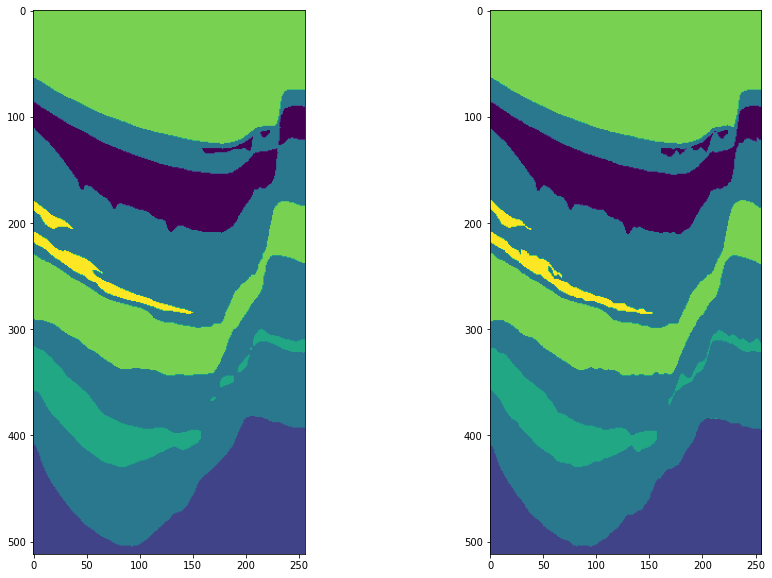

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(gy_label)
axarr[1].imshow(training_label_data[420])

In [ ]:
training_label_data[420]

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
gy_label

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
lab_patch[:,:,420]

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

In [ ]:
print('The amount of labels on the training label set was: {}.'.format(np.unique(gy_label)), 'The amount of labels on the predicted example is: {}'.format(np.unique(training_label_data[340])))

The amount of labels on the training label set was: [0 1 2 3 4 5]. The amount of labels on the predicted example is: [0 1 2 3 4 5]


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#import torch
#model = torch.load("model_0.pth",map_location='cpu')
#torch.save(model,"/content/drive/My Drive/Colab Notebooks/TestmodelNew11.pth") 

In [ ]:
test_seismic = np.load('/content/data_test_1.npz')['data']

In [ ]:
test_seismic.shape

(1006, 782, 251)

In [ ]:
testing_img_data = []
for i in tqdm(range(0, test_seismic.shape[1])):
  img = test_seismic[:,i,:]
  #img = img/MAX_AMP
  img = np.expand_dims(img, axis=2).astype('float32')
  img = cv2.resize(img, (256, 512))
  testing_img_data.append(img) 

for i in tqdm(range(0, test_seismic.shape[2])):
  img = test_seismic[:,:,i]
  #img = img/MAX_AMP
  img = np.expand_dims(img, axis=2).astype('float32')
  img = cv2.resize(img, (256, 512))
  testing_img_data.append(img) 






testing_img_data = np.asarray(testing_img_data)

In [ ]:
testing_img_data.shape

(1033, 512, 256)

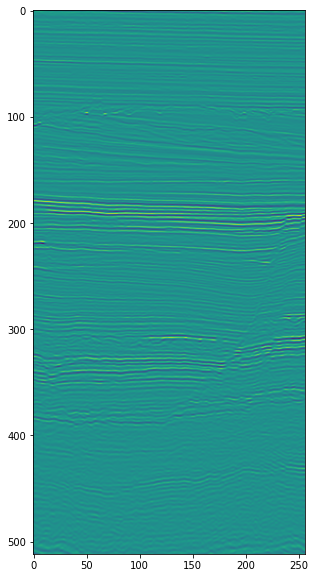

In [ ]:
plt.imshow(testing_img_data[0])

In [ ]:
%%time
preds = []
for i in tqdm(range(0, test_seismic.shape[1])):
  gy_label,gy_onehot=seisfacies_predict(testing_img_data[i],onehot=1)
  #label = gy_label
  #label = np.expand_dims(label, axis=2).astype('float32')
  #label = cv2.resize(label, (251,1006))
  preds.append(gy_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



CPU times: user 3h 13min 7s, sys: 1min 33s, total: 3h 14min 41s
Wall time: 3h 14min 42s


In [ ]:
preds = np.asarray(preds)

In [ ]:
def reshaping(data, out_shape):
  output_labels = []
  for i in data:
    img = np.expand_dims(i, axis=2).astype('float32')
    img = cv2.resize(img, out_shape)
    output_labels.append(img)
  output_labels = np.asarray(output_labels)
  output_labels = output_labels.astype(int) 
  return np.swapaxes(output_labels,0,1) 

In [ ]:
preds = reshaping(preds, (251,1006))

In [ ]:
preds[preds == 0] = 6

In [ ]:
#print(preds.shape, np.unique(preds))

In [ ]:
np.savez_compressed(
    "/content/prediction.npz",
    prediction=preds
)

In [ ]:
preds

array([[[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 